## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [44]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import urllib.request
import re

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

## Datos

In [90]:
# Cargar el dataset
df_cpu = pd.read_csv("./data/df_Cpu.csv")

In [93]:

# Supongamos que tu columna se llama 'identificador'
df_cpu = df_cpu.rename(columns={'identificador': 'id'})

# Mostrar el DataFrame actualizado
print(df_cpu)


                              Cpu  Price_in_euros
0        Intel Core i3 6006U 2GHz          539.00
1     Intel Core i7 6700HQ 2.6GHz          879.01
2      Intel Core i7 7500U 2.7GHz          900.00
3            Intel Core i5 1.8GHz          898.94
4      Intel Core i3 6006U 2.0GHz          428.00
..                            ...             ...
907    Intel Core i5 8250U 1.6GHz          800.00
908    Intel Core i5 6300U 2.4GHz         1629.00
909    Intel Core i5 7200U 2.5GHz          519.00
910  AMD E-Series E2-9000e 1.5GHz          258.00
911   Intel Core i7 7700HQ 2.8GHz         2456.34

[912 rows x 2 columns]


In [100]:
print(parsed_data.columns)

Index(['brand', 'family', 'model', 'generation', 'sku', 'suffix',
       'base_frequency_ghz'],
      dtype='object')


In [95]:

# Función para parsear la columna "Cpu"
def parse_cpu(cpu_name):
    # Verificar si cpu_name es una cadena
    if not isinstance(cpu_name, str):
        return {
            "brand": np.nan,
            "family": np.nan,
            "model": np.nan,
            "generation": np.nan,
            "sku": np.nan,
            "suffix": np.nan,
            "base_frequency_ghz": np.nan
        }
    
    # Diccionario para almacenar los componentes
    components = {
        "brand": np.nan,
        "family": np.nan,
        "model": np.nan,
        "generation": np.nan,
        "sku": np.nan,
        "suffix": np.nan,
        "base_frequency_ghz": np.nan
    }
    
    # Extraer marca
    if "Intel" in cpu_name:
        components["brand"] = "Intel"
        parts = cpu_name.replace("Intel ", "").split()
    elif "AMD" in cpu_name:
        components["brand"] = "AMD"
        parts = cpu_name.replace("AMD ", "").split()
    else:
        return components
    
    # Extraer frecuencia base (último elemento que contiene GHz)
    for part in reversed(parts):
        if "GHz" in part:
            try:
                components["base_frequency_ghz"] = float(part.replace("GHz", ""))
                parts.remove(part)
            except ValueError:
                pass
            break
    
    # Casos especiales (ej: "Intel Core i5 1.6GHz" sin modelo)
    if len(parts) < 2:
        return components
    
    # Familia (ej: "Core i5", "Ryzen 1700")
    components["family"] = " ".join(parts[:2]) if components["brand"] == "Intel" else " ".join(parts[:1])
    
    # Modelo para Intel
    if components["brand"] == "Intel":
        model = parts[2] if len(parts) > 2 else np.nan
        if isinstance(model, str) and model[0].isdigit():
            components["model"] = model
            # Extraer generación y SKU (ej: "8250U" -> gen=8, sku=250)
            if len(model) >= 4:
                components["generation"] = int(model[0]) if model[0].isdigit() else np.nan
                components["sku"] = model[1:4] if model[1:4].isdigit() else np.nan
                components["suffix"] = model[4:] if len(model) > 4 else np.nan
    
    return components

# Aplicar la función a cada fila
parsed_data = df_cpu["Cpu"].apply(lambda x: pd.Series(parse_cpu(x)))

parsed_data



,brand,family,model,generation,sku,suffix,base_frequency_ghz
0,Intel,Core i3,6006U,6.0,006,U,2.0
1,Intel,Core i7,6700HQ,6.0,700,HQ,2.6
2,Intel,Core i7,7500U,7.0,500,U,2.7
3,Intel,Core i5,NaN,NaN,NaN,NaN,1.8
4,Intel,Core i3,6006U,6.0,006,U,2.0
...,...,...,...,...,...,...,...
907,Intel,Core i5,8250U,8.0,250,U,1.6
908,Intel,Core i5,6300U,6.0,300,U,2.4
909,Intel,Core i5,7200U,7.0,200,U,2.5
910,AMD,E-Series,NaN,NaN,NaN,NaN,1.5


In [96]:
parsed_data = parsed_data.rename(columns={'id_parsed': 'id_df'})

In [97]:
parsed_data


,brand,family,model,generation,sku,suffix,base_frequency_ghz
0,Intel,Core i3,6006U,6.0,006,U,2.0
1,Intel,Core i7,6700HQ,6.0,700,HQ,2.6
2,Intel,Core i7,7500U,7.0,500,U,2.7
3,Intel,Core i5,NaN,NaN,NaN,NaN,1.8
4,Intel,Core i3,6006U,6.0,006,U,2.0
...,...,...,...,...,...,...,...
907,Intel,Core i5,8250U,8.0,250,U,1.6
908,Intel,Core i5,6300U,6.0,300,U,2.4
909,Intel,Core i5,7200U,7.0,200,U,2.5
910,AMD,E-Series,NaN,NaN,NaN,NaN,1.5


In [98]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./data/train.csv")
df

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
0,755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
1,618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
2,909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
3,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
4,286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg,800.00
908,1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.48kg,1629.00
909,78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,2TB HDD,Intel HD Graphics 620,No OS,2.2kg,519.00
910,23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,No OS,1.86kg,258.00


In [101]:
print(df.columns)

Index(['laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_in_euros'],
      dtype='object')


In [130]:
df_unido = pd.concat([df, parsed_data], axis=1)

In [131]:
df_unido

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,...,suffix,base_frequency_ghz,total_capacity_gb,brand,family,model,generation,sku,suffix,base_frequency_ghz
0,755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8.0,256GB SSD,Intel HD Graphics 520,...,U,2.0,256.0,Intel,Core i3,6006U,6.0,006,U,2.0
1,618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16.0,1TB HDD,Nvidia GeForce GTX 960<U+039C>,...,HQ,2.6,1000.0,Intel,Core i7,6700HQ,6.0,700,HQ,2.6
2,909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8.0,1TB HDD,Nvidia GeForce 930MX,...,U,2.7,1000.0,Intel,Core i7,7500U,7.0,500,U,2.7
3,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128GB Flash Storage,Intel HD Graphics 6000,...,NaN,1.8,128.0,Intel,Core i5,NaN,NaN,NaN,NaN,1.8
4,286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4.0,1TB HDD,AMD Radeon R5 M430,...,U,2.0,1000.0,Intel,Core i3,6006U,6.0,006,U,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8.0,256GB SSD,AMD Radeon 530,...,U,1.6,256.0,Intel,Core i5,8250U,8.0,250,U,1.6
908,1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8.0,256GB SSD,Intel HD Graphics 520,...,U,2.4,256.0,Intel,Core i5,6300U,6.0,300,U,2.4
909,78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,2TB HDD,Intel HD Graphics 620,...,U,2.5,2000.0,Intel,Core i5,7200U,7.0,200,U,2.5
910,23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4.0,500GB HDD,AMD Radeon R2,...,NaN,1.5,500.0,AMD,E-Series,NaN,NaN,NaN,NaN,1.5


In [132]:
df_memory = df[["Memory","Price_in_euros"]]
df_memory.head()

,Memory,Price_in_euros
0,256GB SSD,539.00
1,1TB HDD,879.01
2,1TB HDD,900.00
3,128GB Flash Storage,898.94
4,1TB HDD,428.00


In [133]:
def parse_memory(memory_str):
    # Diccionario base
    components = {
        "primary_capacity_gb": np.nan,
        "primary_type": np.nan,
        "has_secondary": 0,
        "secondary_capacity_gb": np.nan,
        "secondary_type": np.nan,
        "total_capacity_gb": np.nan
    }
    
    # Expresión regular para extraer capacidad y tipo
    pattern = r"(\d+\.?\d*)(TB|GB|MB)\s*(\w+\s*\w*)"
    
    # Separar combinaciones (ej: "256GB SSD + 1TB HDD")
    drives = re.split(r"\s*\+\s*", memory_str)
    
    # Procesar cada disco
    capacities = []
    types = []
    
    for drive in drives:
        match = re.search(pattern, drive)
        if match:
            value, unit, drive_type = match.groups()
            value = float(value)
            
            # Convertir todo a GB
            multiplier = 1000 if unit == "TB" else 1 if unit == "GB" else 0.001
            capacity_gb = value * multiplier
            
            capacities.append(capacity_gb)
            types.append(drive_type.strip())
    
    if capacities:
        # Primario
        components["primary_capacity_gb"] = capacities[0]
        components["primary_type"] = types[0]
        
        # Secundario (si existe)
        if len(capacities) > 1:
            components["has_secondary"] = 1
            components["secondary_capacity_gb"] = capacities[1]
            components["secondary_type"] = types[1]
        
        # Capacidad total
        components["total_capacity_gb"] = sum(capacities)
    
    return components

In [134]:
# Aplicar la función
parsed_memory = df_memory["Memory"].apply(
    lambda x: pd.Series((parse_memory(x)))
)

In [135]:
# Combinar con el DataFrame original
df = pd.concat([df_unido, parsed_memory["total_capacity_gb"]], axis=1)

In [136]:
df

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,...,base_frequency_ghz,total_capacity_gb,brand,family,model,generation,sku,suffix,base_frequency_ghz,total_capacity_gb
0,755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8.0,256GB SSD,Intel HD Graphics 520,...,2.0,256.0,Intel,Core i3,6006U,6.0,006,U,2.0,256.0
1,618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16.0,1TB HDD,Nvidia GeForce GTX 960<U+039C>,...,2.6,1000.0,Intel,Core i7,6700HQ,6.0,700,HQ,2.6,1000.0
2,909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8.0,1TB HDD,Nvidia GeForce 930MX,...,2.7,1000.0,Intel,Core i7,7500U,7.0,500,U,2.7,1000.0
3,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128GB Flash Storage,Intel HD Graphics 6000,...,1.8,128.0,Intel,Core i5,NaN,NaN,NaN,NaN,1.8,128.0
4,286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4.0,1TB HDD,AMD Radeon R5 M430,...,2.0,1000.0,Intel,Core i3,6006U,6.0,006,U,2.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8.0,256GB SSD,AMD Radeon 530,...,1.6,256.0,Intel,Core i5,8250U,8.0,250,U,1.6,256.0
908,1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8.0,256GB SSD,Intel HD Graphics 520,...,2.4,256.0,Intel,Core i5,6300U,6.0,300,U,2.4,256.0
909,78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,2TB HDD,Intel HD Graphics 620,...,2.5,2000.0,Intel,Core i5,7200U,7.0,200,U,2.5,2000.0
910,23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4.0,500GB HDD,AMD Radeon R2,...,1.5,500.0,AMD,E-Series,NaN,NaN,NaN,NaN,1.5,500.0


## Exploración de los datos

## Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [139]:
features = [
    "Inches",
    "brand",
    "Ram"
]

target = [
    "Price_in_euros"
]

-----------------------------------------------------------------------------------------------------------------

In [140]:
# Aplicar One-Hot Encoding a la columna categórica
data_encoded = pd.get_dummies(df, columns=['brand'], drop_first=False)



In [144]:
data_encoded

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,...,model,generation,sku,suffix,base_frequency_ghz,total_capacity_gb,brand_AMD,brand_Intel,brand_AMD,brand_Intel
0,755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8.0,256GB SSD,Intel HD Graphics 520,...,6006U,6.0,006,U,2.0,256.0,False,True,False,True
1,618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16.0,1TB HDD,Nvidia GeForce GTX 960<U+039C>,...,6700HQ,6.0,700,HQ,2.6,1000.0,False,True,False,True
2,909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8.0,1TB HDD,Nvidia GeForce 930MX,...,7500U,7.0,500,U,2.7,1000.0,False,True,False,True
3,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128GB Flash Storage,Intel HD Graphics 6000,...,NaN,NaN,NaN,NaN,1.8,128.0,False,True,False,True
4,286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4.0,1TB HDD,AMD Radeon R5 M430,...,6006U,6.0,006,U,2.0,1000.0,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8.0,256GB SSD,AMD Radeon 530,...,8250U,8.0,250,U,1.6,256.0,False,True,False,True
908,1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8.0,256GB SSD,Intel HD Graphics 520,...,6300U,6.0,300,U,2.4,256.0,False,True,False,True
909,78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,2TB HDD,Intel HD Graphics 620,...,7200U,7.0,200,U,2.5,2000.0,False,True,False,True
910,23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4.0,500GB HDD,AMD Radeon R2,...,NaN,NaN,NaN,NaN,1.5,500.0,True,False,True,False


In [153]:
features = [
    "Inches",
    "brand",
    "Ram"
]

target = [
    "Price_in_euros"
]

In [154]:
# Dividir en features (X) y target (y)
X = features
y = target


ValueError: Found input variables with inconsistent numbers of samples: [3, 1]

## Modelado

### 1. Definir X e y

In [123]:
# 📌 Escalar las Features (Opcional pero Recomendado)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ValueError: could not convert string to float: 'Intel'

In [11]:
# 📌 Configurar Validación Cruzada con 5 Folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:

# 📌  Definir el Modelo XGBoost
model = XGBRegressor(
    n_estimators=200,       # 100 árboles
    learning_rate=0.2,      # Tasa de aprendizaje
    max_depth=5,            # Profundidad máxima del árbol
    min_child_weight=3,     # Regularización
    subsample=0.8,          # Muestreo de datos
    colsample_bytree=0.8,   # Muestreo de features por árbol
    random_state=42
)

In [13]:
# 📌 6. Evaluar el Modelo con Cross-Validation (Métrica: R²)
scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='r2')

# 📌 7. Mostrar Resultados
print(f"R² en cada fold: {scores}")
print(f"R² promedio: {np.mean(scores):.4f}")

R² en cada fold: [0.63787232 0.65840746 0.74582112 0.58621718 0.66089223]
R² promedio: 0.6578


### 2. Dividir X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### 3. Baseline de modelos


In [15]:
# 6. Entrenar modelo con todos los datos de entrenamiento
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

In [16]:
# 7. Evaluar en conjunto de prueba
y_pred = model.predict(X_test)
print(f"\nMSE Test: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Test: {r2_score(y_test, y_pred):.2f}")


MSE Test: 200049.56
R² Test: 0.64


In [17]:
root_mean_squared_error(y_test,y_pred)

447.2689990665269

In [18]:
# 8. Importancia de las features
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
print("\nImportancia de las features:")
print(feature_importance.sort_values(ascending=False))


Importancia de las features:
Ram                  0.729118
Inches               0.152031
total_capacity_gb    0.118851
dtype: float32


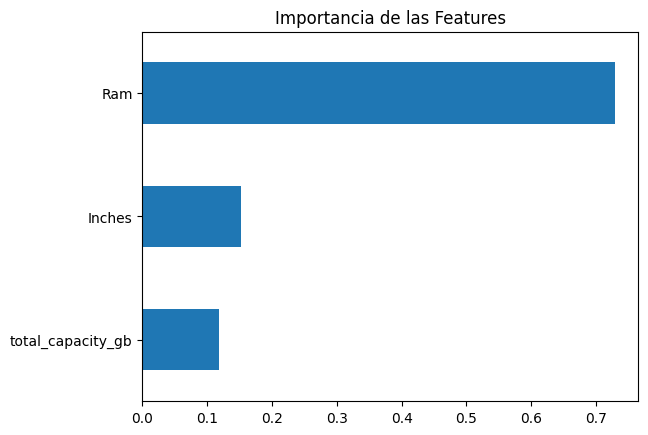

In [19]:
# (Opcional) Visualización de importancia de features
feature_importance.sort_values().plot(kind='barh')
plt.title('Importancia de las Features')
plt.show()

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [20]:
# Para que funcione necesita bajarte los archivos  de datos de Kaggle
X_pred = pd.read_csv("./data/test.csv", index_col = ["laptop_ID"])
X_pred.index.name = None
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           391 non-null    object 
 1   Product           391 non-null    object 
 2   TypeName          391 non-null    object 
 3   Inches            391 non-null    float64
 4   ScreenResolution  391 non-null    object 
 5   Cpu               391 non-null    object 
 6   Ram               391 non-null    object 
 7   Memory            391 non-null    object 
 8   Gpu               391 non-null    object 
 9   OpSys             391 non-null    object 
 10  Weight            391 non-null    object 
dtypes: float64(1), object(10)
memory usage: 36.7+ KB


In [21]:
df_memory_pred = X_pred[["Memory"]]
df_memory_pred.head()


,Memory
209,512GB SSD
1281,500GB HDD
1168,1TB HDD
1231,256GB SSD
1020,256GB SSD


In [22]:
def parse_memory1(memory_str):
    # Diccionario base
    components = {
        "primary_capacity_gb": np.nan,
        "primary_type": np.nan,
        "has_secondary": 0,
        "secondary_capacity_gb": np.nan,
        "secondary_type": np.nan,
        "total_capacity_gb": np.nan
    }
    
    # Expresión regular para extraer capacidad y tipo
    pattern = r"(\d+\.?\d*)(TB|GB|MB)\s*(\w+\s*\w*)"
    
    # Separar combinaciones (ej: "256GB SSD + 1TB HDD")
    drives = re.split(r"\s*\+\s*", memory_str)
    
    # Procesar cada disco
    capacities = []
    types = []
    
    for drive in drives:
        match = re.search(pattern, drive)
        if match:
            value, unit, drive_type = match.groups()
            value = float(value)
            
            # Convertir todo a GB
            multiplier = 1000 if unit == "TB" else 1 if unit == "GB" else 0.001
            capacity_gb = value * multiplier
            
            capacities.append(capacity_gb)
            types.append(drive_type.strip())
    
    if capacities:
        # Primario
        components["primary_capacity_gb"] = capacities[0]
        components["primary_type"] = types[0]
        
        # Secundario (si existe)
        if len(capacities) > 1:
            components["has_secondary"] = 1
            components["secondary_capacity_gb"] = capacities[1]
            components["secondary_type"] = types[1]
        
        # Capacidad total
        components["total_capacity_gb"] = sum(capacities)
    
    return components

In [23]:
# Aplicar la función
parsed_memory1 = df_memory_pred["Memory"].apply(
    lambda x: pd.Series((parse_memory1(x)))
)

In [24]:
parsed_memory1

,primary_capacity_gb,primary_type,has_secondary,secondary_capacity_gb,secondary_type,total_capacity_gb
209,512.0,SSD,0,NaN,NaN,512.0
1281,500.0,HDD,0,NaN,NaN,500.0
1168,1000.0,HDD,0,NaN,NaN,1000.0
1231,256.0,SSD,0,NaN,NaN,256.0
1020,256.0,SSD,0,NaN,NaN,256.0
...,...,...,...,...,...,...
820,512.0,SSD,1,1000.0,HDD,1512.0
948,128.0,SSD,0,NaN,NaN,128.0
483,256.0,SSD,0,NaN,NaN,256.0
1017,500.0,HDD,0,NaN,NaN,500.0


 ## 2. Replicar el procesado para ``test.csv``

In [25]:
# Combinar con el DataFrame original
X_pred = pd.concat([X_pred, parsed_memory1["total_capacity_gb"]], axis=1)

In [26]:
X_pred

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,total_capacity_gb
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg,512.0
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg,500.0
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg,1000.0
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg,256.0
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...
820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg,1512.0
948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg,128.0
483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg,256.0
1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg,500.0


In [27]:
features_X_pred = [
    "Inches",
    "total_capacity_gb",
    "Ram"
]
# X = df.drop(['Price_in_euros'], axis=1)
X = X_pred[features].copy()

X.shape



(391, 3)

In [30]:
X_pred["Ram"]= X_pred["Ram"].str.replace("GB", "").astype(float)
X_pred

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,total_capacity_gb
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16.0,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg,512.0
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4.0,500GB HDD,Intel HD Graphics 400,Linux,2.4kg,500.0
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4.0,1TB HDD,Intel HD Graphics 520,No OS,1.9kg,1000.0
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg,256.0
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4.0,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...
820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16.0,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg,1512.0
948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4.0,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg,128.0
483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8.0,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg,256.0
1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4.0,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg,500.0


In [32]:
features_X_pred = [
    "Inches",
    "total_capacity_gb",
    "Ram"
]
# X = df.drop(['Price_in_euros'], axis=1)
X = X_pred[features].copy()

X.shape

(391, 3)

In [35]:
predictions_submit = model.predict(X)
predictions_submit

array([1713.336  ,  494.50204,  482.8844 , 1009.40546,  978.2319 ,
        563.9327 ,  954.0179 , 1200.9504 , 1623.3167 ,  317.11975,
       2097.7124 , 1368.7805 ,  549.35266, 1713.336  , 1094.3593 ,
        482.8844 , 1713.336  , 1368.7805 , 1332.3383 ,  669.40576,
       1561.3156 ,  407.06122,  980.6265 , 1606.3693 ,  554.22754,
        782.32715,  980.6265 ,  747.5506 , 2475.3784 , 1332.3383 ,
       2097.7124 ,  482.8844 ,  733.24536, 3190.1655 , 1713.336  ,
       2097.7124 ,  482.8844 , 1755.6464 , 1141.0874 , 1368.7805 ,
        782.32715, 1606.3693 ,  554.22754, 1332.3383 , 2805.26   ,
       1141.0874 , 1009.40546,  494.50204, 1009.40546,  473.09222,
       1713.336  ,  782.32715, 1141.0874 ,  494.50204, 1368.7805 ,
       1831.8739 ,  699.6436 ,  980.6265 ,  782.32715,  717.9321 ,
       2220.492  , 1332.3383 ,  669.40576, 2106.588  , 1009.40546,
       1332.3383 ,  978.2319 , 1623.3167 , 1696.2015 , 2097.7124 ,
        494.50204,  343.9906 , 1368.7805 , 1606.3693 , 1009.40

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

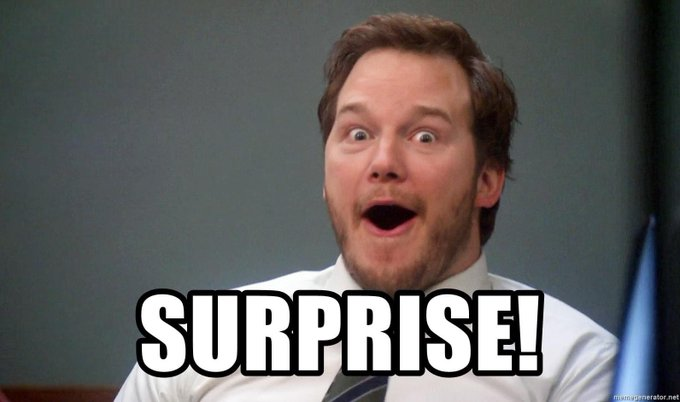

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [36]:
sample = pd.read_csv("data/sample_submission.csv")

In [37]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [38]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [39]:
#¿Cómo creamos la submission?
submission = pd.DataFrame({"laptop_ID": X_pred.index,"Price_in_euros":predictions_submit })

In [40]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1713.336060
1,1281,494.502045
2,1168,482.884399
3,1231,1009.405457
4,1020,978.231873


In [41]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [42]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [43]:
chequeador(submission)

You're ready to submit!
